## Heart Disease Classification
- Theory 
- EDA
    - Sample Integrity
    - Feature Explanation
    - Outliers
- Modeling 
    - Cross Validation
    - Grid Search 
    - Voting Classifier
    - AUC-ROC & PR Curves

**Voting Classifier**
- Similar to what an RFClassifer is to a DTClassifier

- Multiple Classifier Models trained on X_train and tested on X_test:

    - Hard Voting: compare each model's o/p classes independently  
        - mode of o/p class(M1,...,Mn)
    - Soft Voting: max prob. of (mean probab. of each model's indiv. class o/p) 
        - max(meanC1(M1,...,Mn),meanC2(M1,...,Mn),...,meanCn(M1,...,Mn)) 

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, graphviz as gpz


In [2]:
df = pd.read_csv('dataset.csv')
df.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
df.columns = ['age','sex','chestpaintype','restingbp','chol','fastingbldsgr','restecg','maxhr','exerciseangina','oldpeak','slope','coronaryarteries','thalassemia','heartdisease']
df.columns

Index(['age', 'sex', 'chestpaintype', 'restingbp', 'chol', 'fastingbldsgr',
       'restecg', 'maxhr', 'exerciseangina', 'oldpeak', 'slope',
       'coronaryarteries', 'thalassemia', 'heartdisease'],
      dtype='object')

Feature Set:
- continuous
    - age (yrs)
    - restingbp 
    - cholesterol 
    - maxhr (60-202)
    - oldpeak
- categorical
    - sex (m=0/f=1)
    - cptype (0,1,2,3)
    - fastingbs (0,1)
    - restingecg (0,1,2)
    - exang (0,1)
    - slope (0,1,2)
    - ca (0,1,2,3,4)
    - thal (0,1,2,3)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               303 non-null    int64  
 1   sex               303 non-null    int64  
 2   chestpaintype     303 non-null    int64  
 3   restingbp         303 non-null    int64  
 4   chol              303 non-null    int64  
 5   fastingbldsgr     303 non-null    int64  
 6   restecg           303 non-null    int64  
 7   maxhr             303 non-null    int64  
 8   exerciseangina    303 non-null    int64  
 9   oldpeak           303 non-null    float64
 10  slope             303 non-null    int64  
 11  coronaryarteries  303 non-null    int64  
 12  thalassemia       303 non-null    int64  
 13  heartdisease      303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


### Preprocessing

In [5]:
#imbalance check
import plotly.express as px
labels = ['healthy','heartdisease']
check = df['heartdisease'].value_counts().tolist()
fig = px.pie(values=check,names=labels,color_discrete_sequence=['skyblue','black'],title='healthy vs heartdisease')
fig

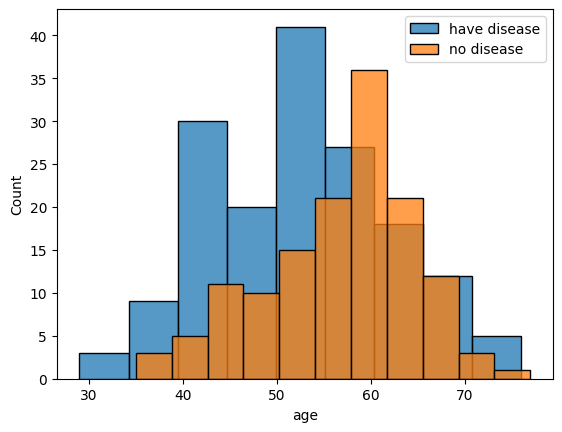

In [121]:
#Visualize the age and whether a patient has disease or not
dfy = df[df['heartdisease']==1]
dfn = df[df['heartdisease']==0]
axs = sns.histplot(data=dfy,x='age',label='have disease')
axs = sns.histplot(data=dfn,x='age',label='no disease')
axs.legend()

In sample: <br>

Middle ages have higher prevalence of heart disease (40-60) and thus higher chance of contracting hd. <br>

Younger people are less affected by hd. <br>

Older ages are past the stresses of life and are less affected by hd.

Data is Sufficiently Balanced

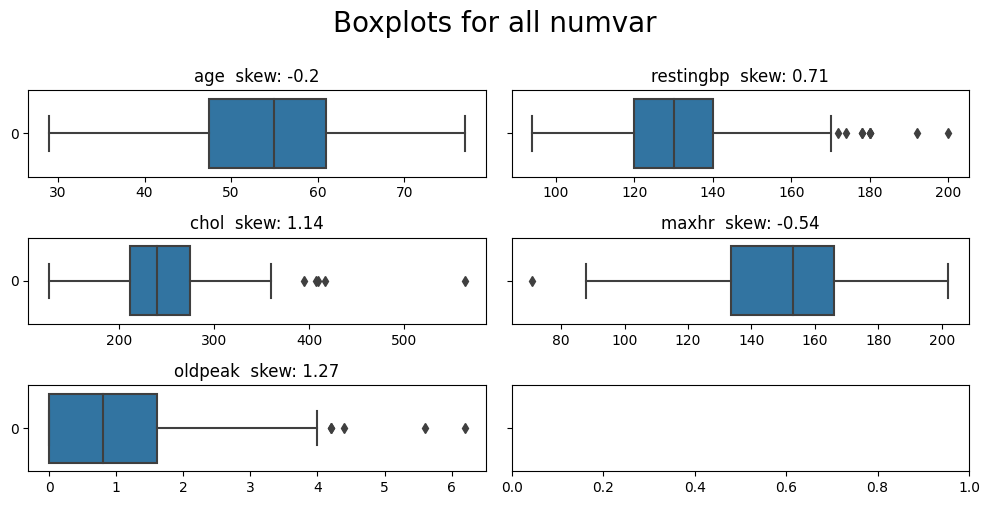

In [6]:
#viz outliers
#seperate numerical cols
numcol = list(df.loc[:,['age', 'restingbp', 'chol','maxhr','oldpeak']])
#multiple boxplot
def custombox(ipdata,ipcols,numrow,numcol,title):
    fig,axs = plt.subplots(numrow,numcol,sharey=True,figsize=(10,5))
    fig.suptitle(title,y=1,size=20)
    axs = axs.flatten()
    for i,data in enumerate(ipcols):
        sns.boxplot(data=ipdata[data],orient='h',ax=axs[i])
        axs[i].set_title(data+'  skew: '+str(round(ipdata[data].skew(axis=0),2)))
custombox(ipdata=df,ipcols=numcol,numrow=3,numcol=2,title='Boxplots for all numvar')
plt.tight_layout()

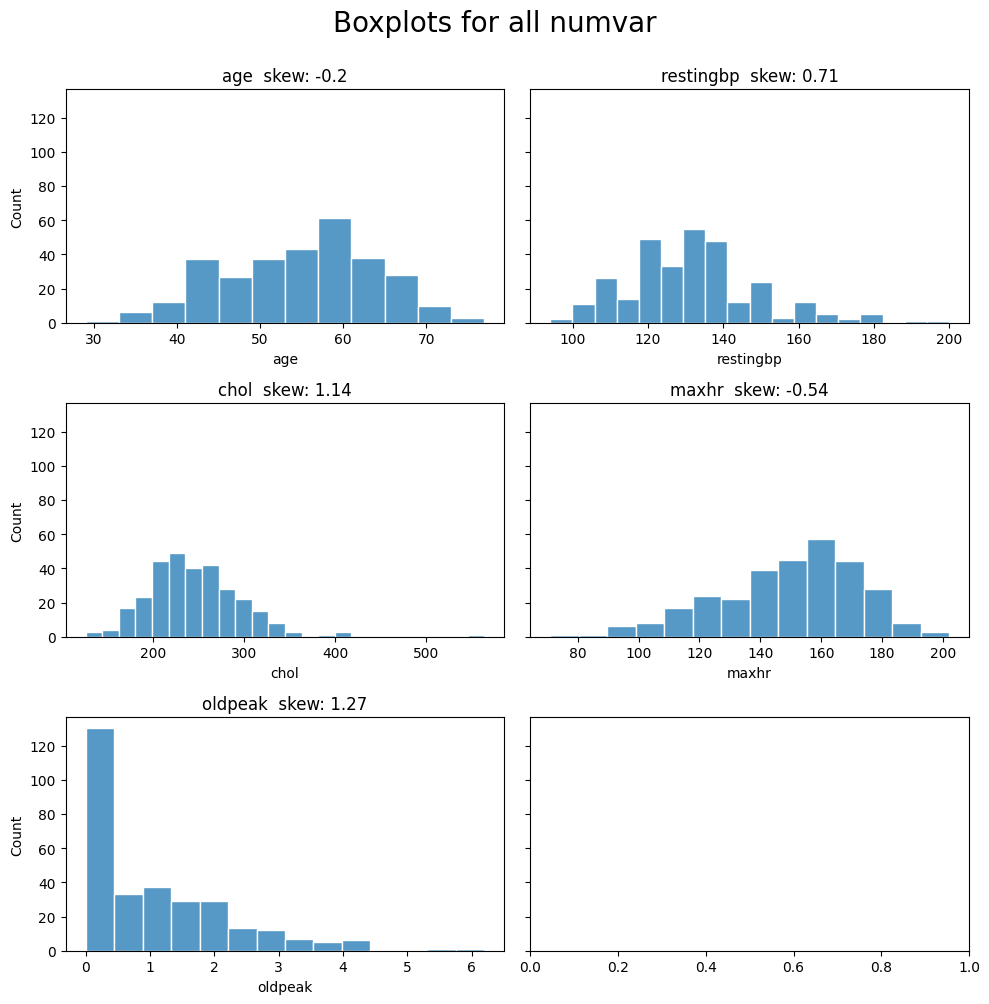

In [7]:
#multiple histplot
def customhist(ipdata,ipcols,numrow,numcol,title):
    fig,axs = plt.subplots(numrow,numcol,sharey=True,figsize=(10,10))
    fig.suptitle(title,y=1,size=20)
    axs = axs.flatten()
    for i,data in enumerate(ipcols):
        sns.histplot(data=ipdata[data],ax=axs[i],edgecolor='white')
        axs[i].set_title(data+'  skew: '+str(round(ipdata[data].skew(axis=0),2)))
customhist(ipdata=df,ipcols=numcol,numrow=3,numcol=2,title='Boxplots for all numvar')
plt.tight_layout()

In [47]:
#using Tukey's IQR detection to omit outliers:
from collections import Counter
def iqr(data,n,features):
    outlier_list=[]
    for column in features:
        Q1 = np.percentile(data[column],25)
        Q3 = np.percentile(data[column],75)
        IQR = Q3-Q1
        #range to define outliers
        outlier_step = 1.5*IQR
        #add outlier indices to outliers list
        outlier_list_col = data[(data[column]<Q1 - outlier_step)|(data[column]>Q3+outlier_step)].index
        #add indices to list of outliers
        outlier_list.extend(outlier_list_col)
    
    #if index has more than one outlier value add to multiple outlier list
    outlier_list = Counter(outlier_list)
    #n is min repeated index threshold
    multipleoutliers = list(k for k, v in outlier_list.items() if v > n)

    print('Total number of outliers is:', len(multipleoutliers))
    return multipleoutliers

outliers_count = iqr(df,0,numcol)

Total number of outliers is: 19


In [43]:
#drop outliers
df1 = df.drop(outliers_count,axis = 0).reset_index(drop=True)

In [55]:
df2 = pd.get_dummies(df1, drop_first=True)
df2.head()

,age,sex,chestpaintype,restingbp,chol,fastingbldsgr,restecg,maxhr,exerciseangina,oldpeak,slope,coronaryarteries,thalassemia,heartdisease
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [56]:
X = df2.drop('heartdisease',axis=1)
y = df2['heartdisease']

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(X,y,random_state=56,test_size=0.3)

In [60]:
#scaling
from sklearn.preprocessing import StandardScaler
def StdScl(df,colnames):
    features = df[colnames]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[colnames] = features
    return df

colnames = numcol
X_train = StdScl(X_train,colnames)
X_test = StdScl(X_test,colnames)

In [445]:
#Modeling
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

#set kfold for consistent splits
kf = KFold(n_splits=5,shuffle=False)

In [349]:
rf = RandomForestClassifier(n_estimators=25,random_state=56)
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)
rf_cm = confusion_matrix(y_test,rf_pred)
rf_acc = accuracy_score(y_test,rf_pred)
rf_cr = classification_report(y_test,rf_pred)
print('conf mx: ','\n',rf_cm,'\n\n','accuracy score:',rf_acc,'\n\n',rf_cr)

conf mx:  
 [[37  7]
 [ 5 37]] 

 accuracy score: 0.8604651162790697 

               precision    recall  f1-score   support

           0       0.88      0.84      0.86        44
           1       0.84      0.88      0.86        42

    accuracy                           0.86        86
   macro avg       0.86      0.86      0.86        86
weighted avg       0.86      0.86      0.86        86



In [356]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
lr_pred = lr.predict(X_test)
lr_cm = confusion_matrix(y_test,lr_pred)
lr_acc = accuracy_score(y_test,lr_pred)
lr_cr = classification_report(y_test,lr_pred)
print('conf mx: ','\n',lr_cm,'\n\n','accuracy score:',lr_acc,'\n\n',lr_cr)

conf mx:  
 [[34 10]
 [ 2 40]] 

 accuracy score: 0.8604651162790697 

               precision    recall  f1-score   support

           0       0.94      0.77      0.85        44
           1       0.80      0.95      0.87        42

    accuracy                           0.86        86
   macro avg       0.87      0.86      0.86        86
weighted avg       0.87      0.86      0.86        86



In [444]:
dt = DecisionTreeClassifier(max_depth=90,criterion = 'entropy')
dt.fit(X_train,y_train)
dt_pred = dt.predict(X_test)
dt_cm = confusion_matrix(y_test,dt_pred)
dt_acc = accuracy_score(y_test,dt_pred)
dt_cr = classification_report(y_test,dt_pred)
print('conf mx: ','\n',dt_cm,'\n\n','accuracy score:',dt_acc,'\n\n',dt_cr)

conf mx:  
 [[33 11]
 [ 9 33]] 

 accuracy score: 0.7674418604651163 

               precision    recall  f1-score   support

           0       0.79      0.75      0.77        44
           1       0.75      0.79      0.77        42

    accuracy                           0.77        86
   macro avg       0.77      0.77      0.77        86
weighted avg       0.77      0.77      0.77        86



**Recall: TP/(TP+FN)**
- Recall is key in heart disease detection because False Negatives fail to correctly identify a patient's illness. This can be fatal. 


**Using KFold Cross Validation**:
- Small sample
- Resample to improve evalution of model on limited data

In [458]:
from statistics import stdev
from sklearn.model_selection import cross_val_score
score = cross_val_score(rf,X_train,y_train,cv=kf,scoring='recall')
rfcvscore = score.mean()
rfcvstdev = stdev(score)
print('recall score:',score)
print('mean recall score:',rfcvscore)
print('stdev recall:',rfcvstdev)

recall score: [0.96153846 0.95833333 0.77777778 0.94736842 0.9047619 ]
mean recall score: 0.9099559796928218
stdev recall: 0.07729629199223952


In [459]:
score = cross_val_score(lr,X_train,y_train,cv=kf,scoring='recall')
rfcvscore = score.mean()
rfcvstdev = stdev(score)
print('recall score:',score)
print('mean recall score:',rfcvscore)
print('stdev recall:',rfcvstdev)

recall score: [0.92307692 0.95833333 0.85185185 0.89473684 0.85714286]
mean recall score: 0.8970283615020458
stdev recall: 0.04492729870207505


In [460]:
score = cross_val_score(dt,X_train,y_train,cv=kf,scoring='recall')
rfcvscore = score.mean()
rfcvstdev = stdev(score)
print('recall score:',score)
print('mean recall score:',rfcvscore)
print('stdev recall:',rfcvstdev)

recall score: [0.73076923 0.91666667 0.74074074 0.78947368 0.76190476]
mean recall score: 0.7879110168583854
stdev recall: 0.07541054841663834


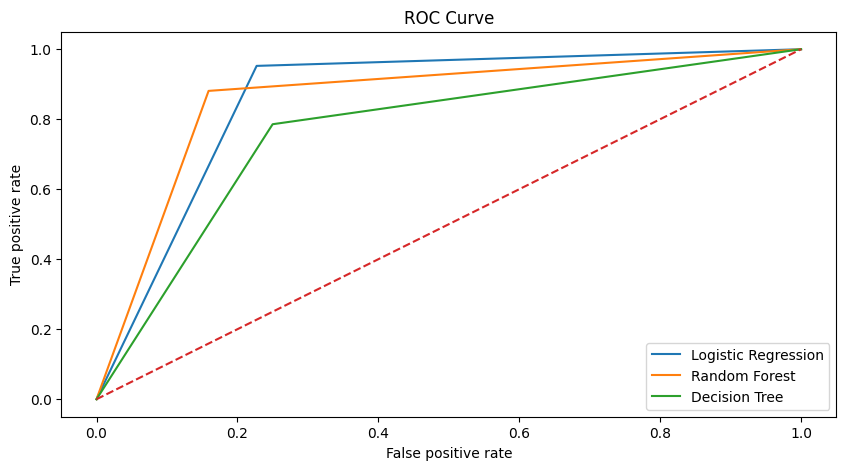

In [467]:
lr_false_positive_rate,lr_true_positive_rate,lr_threshold = roc_curve(y_test,lr_pred)
rf_false_positive_rate,rf_true_positive_rate,rf_threshold = roc_curve(y_test,rf_pred)                                                             
dt_false_positive_rate,dt_true_positive_rate,dt_threshold = roc_curve(y_test,dt_pred)

plt.figure(figsize=(10,5))
plt.title('ROC Curve')
plt.plot(lr_false_positive_rate,lr_true_positive_rate,label='Logistic Regression')
plt.plot(rf_false_positive_rate,rf_true_positive_rate,label='Random Forest')
plt.plot(dt_false_positive_rate,dt_true_positive_rate,label='Decision Tree')

plt.plot([0,1],ls='--')

plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

Decision Tree model is not competitive.<br>
Log Regr Model is competitive but overall Random Forest model has a better recall and accuracy score. <br>